# shower-event.py
https://github.com/grand-mother/grand/blob/master/examples/simulation/shower-event.py

In this example we compute the voltage at antenna output for a given simulated shower. This consist basically in a scalar product between the Efield vector and the antenna effective length, the complex vectorial information encoding the antenna response:
$$ V = \vec{E} \cdot \vec{l_{eff}}$$

More details on the effective length & voltage computation can be found in particular here: https://github.com/grand-mother/hands_on/blob/master/GRANDscripts/GRANDscripts.pdf





First we import relevant packages.




In [1]:
#! /usr/bin/env python
import numpy as np
from matplotlib import pyplot as plt
from grand import LTP

params = {'legend.fontsize': 16,
          'axes.labelsize' : 22,
          'axes.titlesize' : 23,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'figure.figsize' : (10, 8),
          'axes.grid'      : True}
plt.rcParams.update(params)

From GRAND, most important modules are Antenna (https://github.com/grand-mother/grand/blob/master/grand/simulation/antenna/generic.py) and ShowerEvent (https://github.com/grand-mother/grand/blob/master/examples/simulation/shower-event.py). 

Two important remarks:
- For the purpose of illustration in this example, jupyter notebooks defining these classes are used here for these classes rather than their (standard) python implementation. This allows additionnal printing & plotting.
- "Kernel restart" is necessary if you want any modification that you may apply for test purposes to these notebooks to be taken into account. 

In [2]:
from grand.simulation import Antenna, ShowerEvent, TabulatedAntennaModel

## Import notebooks derived from the standard scripts
# if you do not have ipynb installed: pip3 install ipynb
from ipynb.fs.full.antenna import *
from ipynb.fs.full.tabulated import *
from ipynb.fs.full.shower_generic import *
#from ipynb.fs.full.zhaires import *
#%matplotlib notebook


Now we load the Shower object from the (Zhaires) example file, available through this command: 

> wget https://github.com/grand-mother/store/releases/download/101/zhaires-test.tar.gz

Note: the method to load the object directly from sim output is only temporary. Soon enough this will be replaced through readuing from a (standardized) simulation file (HDF5 or ROOT).

In [3]:
# Load the radio shower simulation data
shower = ShowerEvent.load('../../tests/simulation/data/zhaires')

'''print("Shower framinp['core']e=",shower.frame)
print("Zenith (Zhaires conv) =",shower.zenith)
print("Azimuth (Zhaires conv) =",shower.azimuth)
print("Xmax=",shower.maximum)
#shower.core=CartesianRepresentation(0, 0, 2900, unit='m')
print("Core=",shower.core)'''

print('---------------------------------')
print("Zenith (Zhaires?!) =",shower.zenith)
print("Azimuth (Zhaires?!) =",shower.azimuth)
print("Xmax=",shower.maximum.flatten())
print("Core=",shower.core.flatten())
print("obstime=", shower.frame.obstime, '\n')
print("Shower frame:")
print(vars(shower.frame))


### zhaires.py: reading groundaltitude from. inp file.
---------------------------------
Zenith (Zhaires?!) = 85.2
Azimuth (Zhaires?!) = 0.0
Xmax= [150750.      0.  15560.]
Core= [   0.    0. 2900.]
obstime= 2019-10-31 00:00:00 

Shower frame:
{'location': ECEF([[-202152.61540589],
      [4968285.91242108],
      [3981091.07392567]]), 'basis': array([[ 0.01295558, -0.62749801,  0.77851037],
       [ 0.99941496,  0.03277239,  0.00978356],
       [-0.03165281,  0.77792815,  0.62755548]]), 'orientation': 'NWU', 'magnetic': True, 'declination': 0.72, 'magmodel': 'IGRF13', 'obstime': datetime.datetime(2019, 10, 31, 0, 0)}


The shower is associated with a Local Tangeant Plane frame centered on the shower core. Hence the Xmax altitude given here is the height above ground, and not above sea level.

Note: using ground altitude at the reference might not be the most natural choice. Sea level is probably more convenient (and less error-prone!)

Now we load the Antenna model, which contains the effective length information, under the form of 4 matrixes (modulus and phase for the 2 componants $l_{eff}^{\theta}$ and $l_{eff}^{\phi}$) with 3 dimensions (frequency, zenith, angle). 

This is done here: https://github.com/grand-mother/grand/blob/be5333a4abfd0f0c0b30835e65c689bfcc798f04/grand/simulation/antenna/tabulated.py#L47


In [4]:
# Define an antenna model
#
# A tabulated model of the Butterfly antenna is used. Note that a single EW
# arm is assumed here for the sake of simplicity

antenna_model = TabulatedAntennaModel.load('./HorizonAntenna_EWarm_leff_loaded.npy')

We then loop on all antennas.

antenna.computevoltage is called with parameters:
- direction = vector $\vec{X_{max}X_{ant}}$
- Electric field info at this antenna
- antenna frame (LTP centered at antenna)

In compute voltage, we do the following: 
- Convert the Efield timetraces ($E_x(t),E_y(t),E_z(t)$) expressed in the Efield frame, an LTP centered @ core) in the frequency domain through FFT
- Compute the Leff values for the direction "direction" where the radiation comes from. These are interpolatted from tabulated values in https://github.com/grand-mother/grand/blob/be5333a4abfd0f0c0b30835e65c689bfcc798f04/grand/simulation/antenna/tabulated.py#L123.
- Write the Leff vector in the E_field frame.
- Perform the scalar product $\vec{E} \cdot \vec{L_{eff}}$ in the frequency domain and come back to the time domain through inverse Fourier transform.

Result is $V(t)$ for this (EW) antenna arm.


0 Antenna pos in shower frame [   0.    270.45 2900.  ]
antenna pos LTP in shower frame:
{'location': ECEF([[-202152.61540589],
      [4968285.91242108],
      [3981091.07392567]]), 'basis': array([[ 0.01295558, -0.62749801,  0.77851037],
       [ 0.99941496,  0.03277239,  0.00978356],
       [-0.03165281,  0.77792815,  0.62755548]]), 'orientation': 'NWU', 'magnetic': True, 'declination': 0.72, 'magmodel': 'IGRF13', 'obstime': datetime.datetime(2019, 10, 31, 0, 0)} [   0.    270.45 2900.  ]
--------------------------------- 

antenna frame:
{'location': ECEF([[-201974.11678087],
      [4970550.76736107],
      [3982913.63079562]]), 'basis': array([[ 0.01582394, -0.62740147,  0.77853517],
       [ 0.99937499,  0.0345403 ,  0.00752257],
       [-0.03161051,  0.77792954,  0.6275559 ]]), 'orientation': 'NWU', 'magnetic': True, 'declination': 0.5536012942405932, 'magmodel': 'IGRF13', 'obstime': datetime.datetime(2019, 10, 31, 0, 0)}
--------------------------------- 


Vpp= 37.7748549021477

/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/coordinates.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  obj[0] = x                    # replace x-coordinates with input x. x can be int, float, or ndarray.
/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/coordinates.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  obj[1] = y                    # replace y-coordinates with input y. y can be int, float, or ndarray.
/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/coordinates.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  obj[2] = z                    # replace z-coordinates with input z. z can be int, float, or ndarray.


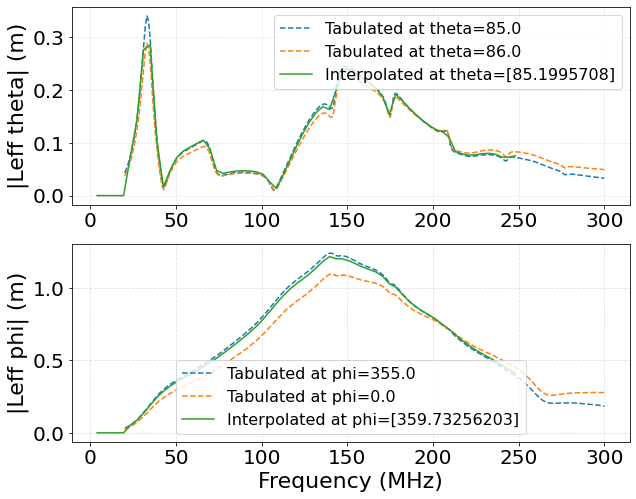

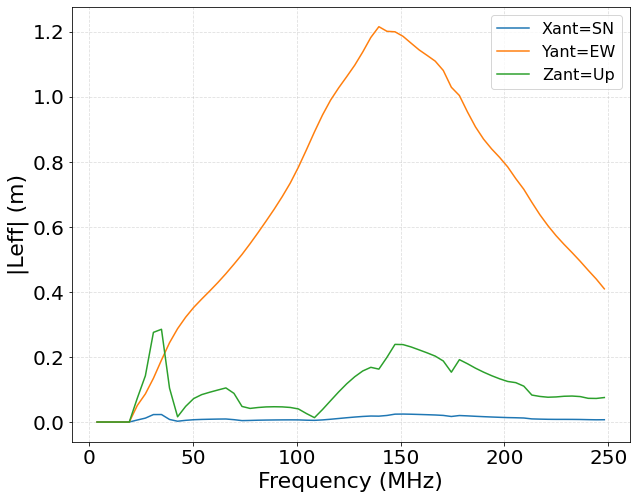

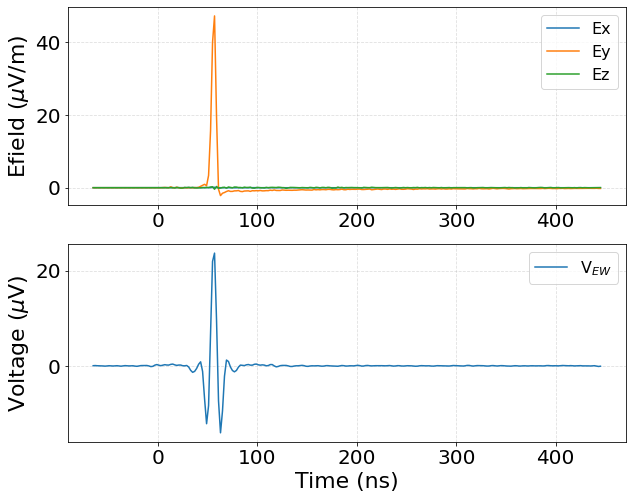

---------------------------------------------------------------

Type return for next antenna
1 Antenna pos in shower frame [-2294.94   191.24  2900.  ]
antenna pos LTP in shower frame:
{'location': ECEF([[-202152.61540589],
      [4968285.91242108],
      [3981091.07392567]]), 'basis': array([[ 0.01295558, -0.62749801,  0.77851037],
       [ 0.99941496,  0.03277239,  0.00978356],
       [-0.03165281,  0.77792815,  0.62755548]]), 'orientation': 'NWU', 'magnetic': True, 'declination': 0.72, 'magmodel': 'IGRF13', 'obstime': datetime.datetime(2019, 10, 31, 0, 0)} [-2294.94   191.24  2900.  ]
--------------------------------- 

antenna frame:
{'location': ECEF([[-202083.01271901],
      [4971988.24175174],
      [3981126.22125148]]), 'basis': array([[ 0.01585882, -0.62711924,  0.77876181],
       [ 0.9993739 ,  0.0345782 ,  0.00749364],
       [-0.03162759,  0.77815539,  0.62727497]]), 'orientation': 'NWU', 'magnetic': True, 'declination': 0.5513119450336319, 'magmodel': 'IGRF13', 'obstime

/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/coordinates.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  obj[0] = x                    # replace x-coordinates with input x. x can be int, float, or ndarray.
/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/coordinates.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  obj[1] = y                    # replace y-coordinates with input y. y can be int, float, or ndarray.
/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/coordinates.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  obj[2] = z                    # replace z-coordinates with input z. z can be int, float, or ndarray.


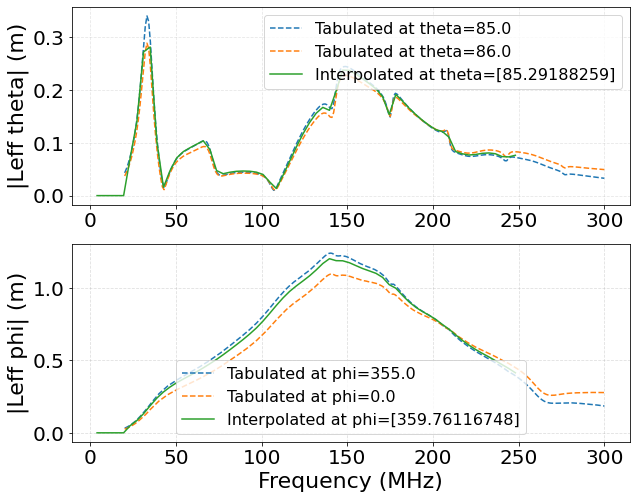

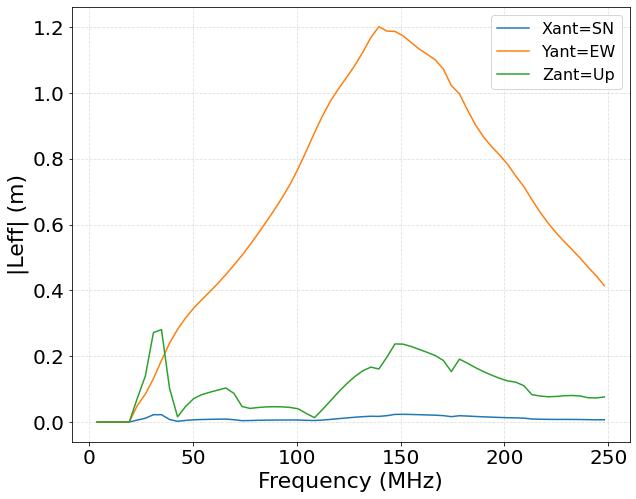

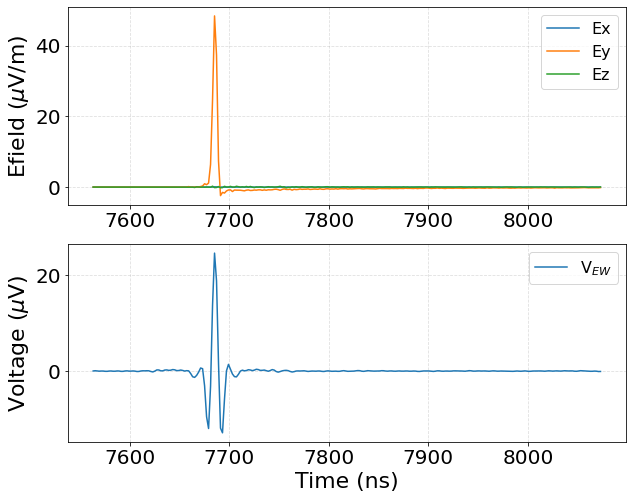

---------------------------------------------------------------



In [ ]:
# Loop over electric fields and compute the corresponding voltages
for antenna_index, field in shower.fields.items():

    # Compute the antenna local frame
    #
    # The antenna is placed in the shower frame. It is oriented along the
    # local magnetic North by using an NWU/LTP frame (x: North, y: West, z: Upward)
    # RK: if antenna location was saved in LTP frame in zhaires.py, next step would not required.
    antpos_wrt_shower= field.electric.r 
    antenna_location = LTP(x=antpos_wrt_shower.x, y=antpos_wrt_shower.y, 
                           z=antpos_wrt_shower.z, frame=shower.frame)
    antenna_frame = LTP(location=antenna_location, orientation='NWU',
                        magnetic=True, obstime=shower.frame.obstime)
    antenna = Antenna(model=antenna_model, frame=antenna_frame)

    print(antenna_index,"Antenna pos in shower frame", antpos_wrt_shower.flatten())
    print("antenna pos LTP in shower frame:")
    print(vars(antenna_location), antenna_location.flatten())
    print('---------------------------------', '\n')
    print('antenna frame:')
    print(vars(antenna_frame))
    print('---------------------------------', '\n')
    
    # Compute the voltage on the antenna
    #
    # The electric field is assumed to be a plane-wave originating from the
    # shower axis at the depth of maximum development. Note that the direction
    # of observation and the electric field components are provided in the
    # shower frame. This is indicated by the `frame` named argument.
    Exyz = field.electric.E
    
    # Xmax, Efield, and input frame are all in shower frame.
    field.voltage = antenna.compute_voltage(shower.maximum, field.electric, frame=shower.frame)

    print("\nVpp=",max(field.voltage.V)-min(field.voltage.V), '\n')

    plt.figure()
    plt.subplot(211)
    plt.plot(1e9*field.electric.t,Exyz.x,label='Ex')
    plt.plot(1e9*field.electric.t,Exyz.y,label='Ey')
    plt.plot(1e9*field.electric.t,Exyz.z,label='Ez')
    #plt.xlabel('Time (ns)')
    plt.ylabel(r'Efield ($\mu$V/m)')
    plt.legend(loc='best')
    plt.grid(ls='--', alpha=0.4)
    plt.subplot(212)
    plt.plot(1e9*field.voltage.t,field.voltage.V,label='V$_{EW}$')
    plt.xlabel('Time (ns)')
    plt.ylabel(r'Voltage ($\mu$V)')
    plt.legend(loc='best')
    plt.grid(ls='--', alpha=0.4)
    plt.show()
    print("---------------------------------------------------------------\n")
    input("Type return for next antenna\n")
    
